## Install Dependencies

In [2]:
from IPython.display import clear_output
!pip install torch
!pip install torchvision
!pip install captum
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install cleverhans
!pip install cachetools
!pip install pandas
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
clear_output()

In [3]:
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

import gc
from load_skin import load_skin_data
import main
import roc_curve

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Dataset

In [4]:
train_loader, val_loader = load_skin_data()

/root/load_skin.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


## Model

In [5]:
model = torch.load('model/skin/model_skin.pth')

## Attacks

In [6]:
from IPython.display import clear_output
!pip install captum
!pip install cleverhans
clear_output()

In [7]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import GradientShap
from captum.attr import visualization as viz
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent
)

## Eps

In [8]:
eps = [8/255, 16/255, 32/255, 64/255]

# GRAD

In [9]:
algorithm = Saliency(model)

## Benign Images to Find Threshold (GRAD)

In [11]:
num_batches = 20

resgrad = main.run_benign(algorithm, model, val_loader, num_batches)

/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete


## PGD (GRAD)

In [13]:
res_pgd1 = main.run_pgd(algorithm, model, val_loader, eps[0], num_batches)
res_pgd2 = main.run_pgd(algorithm, model, val_loader, eps[1], num_batches)
res_pgd3 = main.run_pgd(algorithm, model, val_loader, eps[2], num_batches)
res_pgd4 = main.run_pgd(algorithm, model, val_loader, eps[3], num_batches)

Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete
PGD Calculation Complete
Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribut

In [10]:
import pickle
skin_pgd_grad = {}
# skin_pgd_grad['ben'] = resgrad
# skin_pgd_grad['pgd1'] = res_pgd1
# skin_pgd_grad['pgd2'] = res_pgd2
# skin_pgd_grad['pgd3'] = res_pgd3
# skin_pgd_grad['pgd4'] = res_pgd4
# with open('skin_pgd_grad.pkl', 'wb') as f:
#     pickle.dump(skin_pgd_grad, f)
with open('skin_pgd_grad.pkl', 'rb') as fp:
    skin_pgd_grad = pickle.load(fp)

In [11]:
temp = skin_pgd_grad['pgd1'][0]
skin_pgd_grad['pgd1'][0] = skin_pgd_grad['pgd1'][1] 
skin_pgd_grad['pgd1'][1] = temp

temp = skin_pgd_grad['pgd2'][0]
skin_pgd_grad['pgd2'][0] = skin_pgd_grad['pgd2'][1] 
skin_pgd_grad['pgd2'][1] = temp

temp = skin_pgd_grad['pgd3'][0]
skin_pgd_grad['pgd3'][0] = skin_pgd_grad['pgd3'][1] 
skin_pgd_grad['pgd3'][1] = temp

temp = skin_pgd_grad['pgd4'][0]
skin_pgd_grad['pgd4'][0] = skin_pgd_grad['pgd4'][1] 
skin_pgd_grad['pgd4'][1] = temp

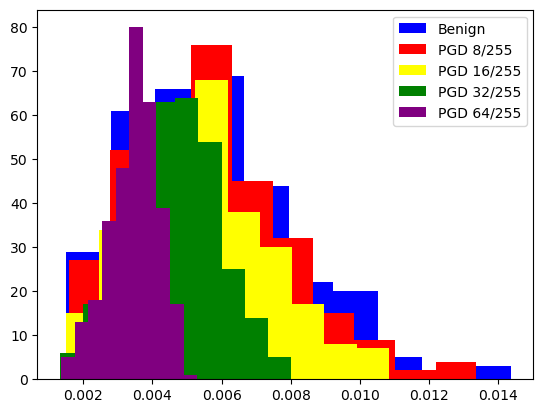

In [22]:
ind = 1

plt.hist(skin_pgd_grad['ben'][ind], label='Benign', color='blue')
plt.hist(skin_pgd_grad['pgd1'][ind], label='PGD 8/255', color='red')
plt.hist(skin_pgd_grad['pgd2'][ind], label='PGD 16/255',  color='yellow')
plt.hist(skin_pgd_grad['pgd3'][ind], label='PGD 32/255', color='green')
plt.hist(skin_pgd_grad['pgd4'][ind], label='PGD 64/255',  color='purple')
plt.legend()
plt.show()

## FGSM (GRAD)

In [28]:
res_fgsm1 = main.run_fgsm(algorithm, model, val_loader, eps[0], num_batches)
res_fgsm2 = main.run_fgsm(algorithm, model, val_loader, eps[1], num_batches)
res_fgsm3 = main.run_fgsm(algorithm, model, val_loader, eps[2], num_batches)
res_fgsm4 = main.run_fgsm(algorithm, model, val_loader, eps[3], num_batches)

Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete
FGSM Calculation Complete
Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribu

In [14]:
skin_fgsm_grad = {}
# skin_fgsm_grad['ben'] = resgrad
# skin_fgsm_grad['fgsm1'] = res_fgsm1
# skin_fgsm_grad['fgsm2'] = res_fgsm2
# skin_fgsm_grad['fgsm3'] = res_fgsm3
# skin_fgsm_grad['fgsm4'] = res_fgsm4
# with open('skin_fgsm_grad.pkl', 'wb') as f:
#     pickle.dump(skin_fgsm_grad, f)
with open('skin_fgsm_grad.pkl', 'rb') as fp:
    skin_fgsm_grad = pickle.load(fp)

In [15]:
temp = skin_fgsm_grad['fgsm1'][0]
skin_fgsm_grad['fgsm1'][0] = skin_fgsm_grad['fgsm1'][1] 
skin_fgsm_grad['fgsm1'][1] = temp

temp = skin_fgsm_grad['fgsm2'][0]
skin_fgsm_grad['fgsm2'][0] = skin_fgsm_grad['fgsm2'][1] 
skin_fgsm_grad['fgsm2'][1] = temp

temp = skin_fgsm_grad['fgsm3'][0]
skin_fgsm_grad['fgsm3'][0] = skin_fgsm_grad['fgsm3'][1] 
skin_fgsm_grad['fgsm3'][1] = temp

temp = skin_fgsm_grad['fgsm4'][0]
skin_fgsm_grad['fgsm4'][0] = skin_fgsm_grad['fgsm4'][1] 
skin_fgsm_grad['fgsm4'][1] = temp

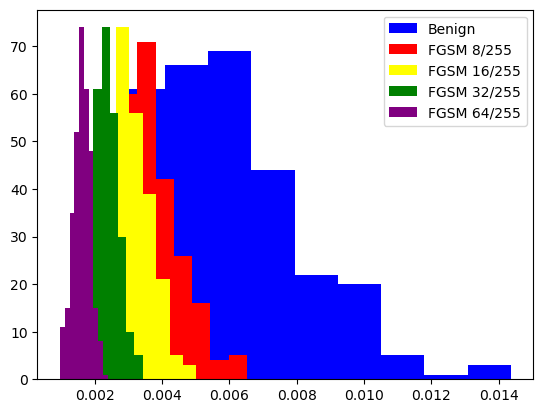

In [17]:
ind = 1
plt.hist(skin_fgsm_grad['ben'][ind], label='Benign', color='blue')
plt.hist(skin_fgsm_grad['fgsm1'][ind], label='FGSM 8/255', color='red')
plt.hist(skin_fgsm_grad['fgsm2'][ind], label='FGSM 16/255',  color='yellow')
plt.hist(skin_fgsm_grad['fgsm3'][ind], label='FGSM 32/255',  color='green')
plt.hist(skin_fgsm_grad['fgsm4'][ind], label='FGSM 64/255',  color='purple')
plt.legend()
plt.show()

[0.1, 0.1, 0.096875, 0.1]
[0.109375, 0.153125, 0.3625, 0.675]


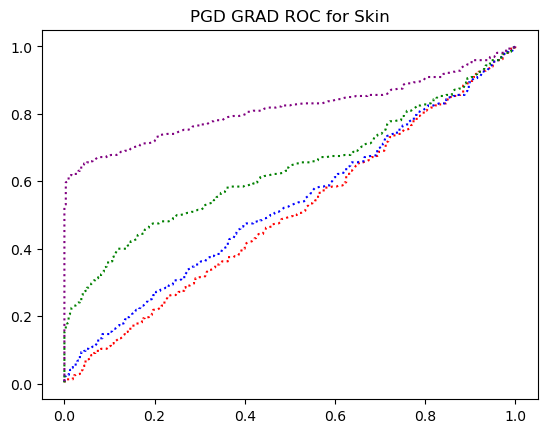

In [28]:
ind = 1
x1, y1 = roc_curve.min_roc_curve(skin_pgd_grad['ben'][ind], skin_pgd_grad['pgd1'][ind], 1000)
x2, y2 = roc_curve.min_roc_curve(skin_pgd_grad['ben'][ind], skin_pgd_grad['pgd2'][ind], 1000)
x3, y3 = roc_curve.min_roc_curve(skin_pgd_grad['ben'][ind], skin_pgd_grad['pgd3'][ind], 1000)
x4, y4 = roc_curve.min_roc_curve(skin_pgd_grad['ben'][ind], skin_pgd_grad['pgd4'][ind], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a, b, c, d in zip(x1, x2, x3, x4):
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    if abs(b - 0.1) < abs(fpr_res[1] - 0.1):
        fpr_res[1] = b
        tpr_res[1] = y2[i]
    if abs(c - 0.1) < abs(fpr_res[2] - 0.1):
        fpr_res[2] = c
        tpr_res[2] = y3[i]
    if abs(d - 0.1) < abs(fpr_res[3] - 0.1):
        fpr_res[3] = d
        tpr_res[3] = y4[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.title("PGD GRAD ROC for Skin")
plt.plot(x1, y1,   "red", linestyle = 'dotted', label = "PGD 8/255")
plt.plot(x2, y2, "blue", linestyle = 'dotted', label = "PGD 16/255")
plt.plot(x3, y3, "green", linestyle = 'dotted', label = "PGD 32/255")
plt.plot(x4, y4, "purple", linestyle = 'dotted', label = "PGD 64/255")
plt.show()

[0.1, 0.1, 0.096875, 0.1]
[0.653125, 0.78125, 0.91875, 0.98125]


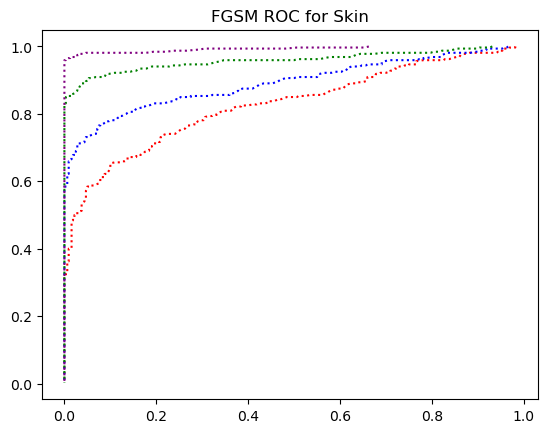

In [27]:
ind = 1
x1, y1 = roc_curve.min_roc_curve(skin_fgsm_grad['ben'][ind], skin_fgsm_grad['fgsm1'][ind], 1000)
x2, y2 = roc_curve.min_roc_curve(skin_fgsm_grad['ben'][ind], skin_fgsm_grad['fgsm2'][ind], 1000)
x3, y3 = roc_curve.min_roc_curve(skin_fgsm_grad['ben'][ind], skin_fgsm_grad['fgsm3'][ind], 1000)
x4, y4 = roc_curve.min_roc_curve(skin_fgsm_grad['ben'][ind], skin_fgsm_grad['fgsm4'][ind], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a, b, c, d in zip(x1, x2, x3, x4):
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    if abs(b - 0.1) < abs(fpr_res[1] - 0.1):
        fpr_res[1] = b
        tpr_res[1] = y2[i]
    if abs(c - 0.1) < abs(fpr_res[2] - 0.1):
        fpr_res[2] = c
        tpr_res[2] = y3[i]
    if abs(d - 0.1) < abs(fpr_res[3] - 0.1):
        fpr_res[3] = d
        tpr_res[3] = y4[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.title("FGSM ROC for Skin")
plt.plot(x1, y1, "red", linestyle = 'dotted')
plt.plot(x2, y2, "blue", linestyle = 'dotted')
plt.plot(x3, y3, "green", linestyle = 'dotted')
plt.plot(x4, y4, "purple", linestyle = 'dotted')
plt.show()

# IG

In [8]:
algorithm = IntegratedGradients(model)

## Benign Images to Find Threshold (IG)

In [9]:
num_batches = 20
ind = 1

resig = main.run_benign(algorithm, model, val_loader, num_batches)

Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete


## PGD (IG)

In [ ]:
res_pgd1ig = main.run_pgd(algorithm, model, val_loader, eps[0], num_batches)
res_pgd2ig = main.run_pgd(algorithm, model, val_loader, eps[1], num_batches)
res_pgd3ig = main.run_pgd(algorithm, model, val_loader, eps[2], num_batches)
res_pgd4ig = main.run_pgd(algorithm, model, val_loader, eps[3], num_batches)

Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete
PGD Calculation Complete
Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribut

In [29]:
import pickle

skin_pgd_ig = {}
# skin_pgd_ig['ben'] = resig
# skin_pgd_ig['pgd1'] = res_pgd1ig
# skin_pgd_ig['pgd2'] = res_pgd2ig
# skin_pgd_ig['pgd3'] = res_pgd3ig
# skin_pgd_ig['pgd4'] = res_pgd4ig
# with open('skin_pgd_ig.pkl', 'wb') as f:
#     pickle.dump(skin_pgd_ig, f)
with open('skin_pgd_ig.pkl', 'rb') as fp:
    skin_pgd_ig = pickle.load(fp)

In [30]:
temp = skin_pgd_ig['pgd1'][0]
skin_pgd_ig['pgd1'][0] = skin_pgd_ig['pgd1'][1] 
skin_pgd_ig['pgd1'][1] = temp

temp = skin_pgd_ig['pgd2'][0]
skin_pgd_ig['pgd2'][0] = skin_pgd_ig['pgd2'][1] 
skin_pgd_ig['pgd2'][1] = temp

temp = skin_pgd_ig['pgd3'][0]
skin_pgd_ig['pgd3'][0] = skin_pgd_ig['pgd3'][1] 
skin_pgd_ig['pgd3'][1] = temp

temp = skin_pgd_ig['pgd4'][0]
skin_pgd_ig['pgd4'][0] = skin_pgd_ig['pgd4'][1] 
skin_pgd_ig['pgd4'][1] = temp

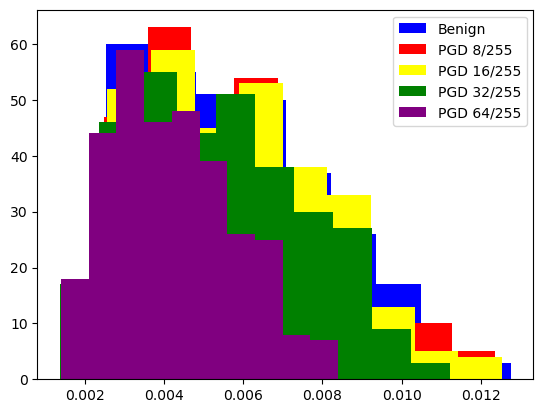

In [34]:
ind = 1
plt.hist(skin_pgd_ig['ben'][ind], label='Benign', color='blue')
plt.hist(skin_pgd_ig['pgd1'][ind], label='PGD 8/255', color='red')
plt.hist(skin_pgd_ig['pgd2'][ind], label='PGD 16/255',  color='yellow')
plt.hist(skin_pgd_ig['pgd3'][ind], label='PGD 32/255',  color='green')
plt.hist(skin_pgd_ig['pgd4'][ind], label='PGD 64/255',  color='purple')
plt.legend()
plt.show()

## FGSM (IG)

In [ ]:
res_fgsm1ig = main.run_fgsm(algorithm, model, val_loader, eps[0], num_batches)
res_fgsm2ig = main.run_fgsm(algorithm, model, val_loader, eps[1], num_batches)
res_fgsm3ig = main.run_fgsm(algorithm, model, val_loader, eps[2], num_batches)
res_fgsm4ig = main.run_fgsm(algorithm, model, val_loader, eps[3], num_batches)

Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete
FGSM Calculation Complete
Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribu

In [35]:
skin_fgsm_ig = {}
# skin_fgsm_ig['ben'] = resig
# skin_fgsm_ig['fgsm1'] = res_fgsm1ig
# skin_fgsm_ig['fgsm2'] = res_fgsm2ig
# skin_fgsm_ig['fgsm3'] = res_fgsm3ig
# skin_fgsm_ig['fgsm4'] = res_fgsm4ig
# with open('skin_fgsm_ig.pkl', 'wb') as f:
#     pickle.dump(skin_fgsm_ig, f)
with open('skin_fgsm_ig.pkl', 'rb') as fp:
    skin_fgsm_ig = pickle.load(fp)

In [36]:
temp = skin_fgsm_ig['fgsm1'][0]
skin_fgsm_ig['fgsm1'][0] = skin_fgsm_ig['fgsm1'][1] 
skin_fgsm_ig['fgsm1'][1] = temp

temp = skin_fgsm_ig['fgsm2'][0]
skin_fgsm_ig['fgsm2'][0] = skin_fgsm_ig['fgsm2'][1] 
skin_fgsm_ig['fgsm2'][1] = temp

temp = skin_fgsm_ig['fgsm3'][0]
skin_fgsm_ig['fgsm3'][0] = skin_fgsm_ig['fgsm3'][1] 
skin_fgsm_ig['fgsm3'][1] = temp

temp = skin_fgsm_ig['fgsm4'][0]
skin_fgsm_ig['fgsm4'][0] = skin_fgsm_ig['fgsm4'][1] 
skin_fgsm_ig['fgsm4'][1] = temp

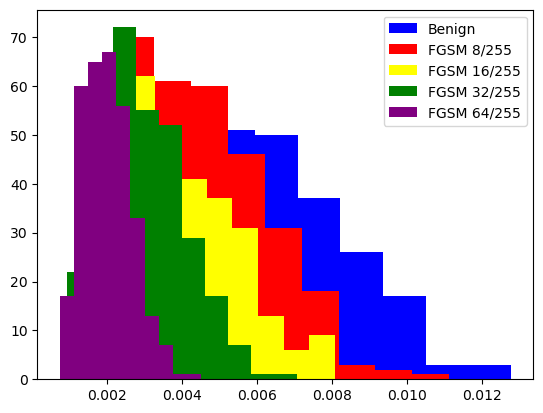

In [38]:
ind = 1
plt.hist(skin_fgsm_ig['ben'][ind], label='Benign', color='blue')
plt.hist(skin_fgsm_ig['fgsm1'][ind], label='FGSM 8/255',  color='red')
plt.hist(skin_fgsm_ig['fgsm2'][ind], label='FGSM 16/255',  color='yellow')
plt.hist(skin_fgsm_ig['fgsm3'][ind], label='FGSM 32/255',  color='green')
plt.hist(skin_fgsm_ig['fgsm4'][ind], label='FGSM 64/255',  color='purple')
plt.legend()
plt.show()

[0.1, 0.1, 0.1, 0.1]
[0.1, 0.09375, 0.1125, 0.35625]


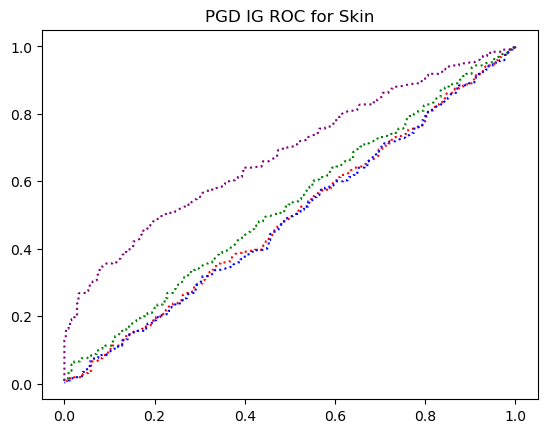

In [39]:
ind = 1
x1, y1 = roc_curve.min_roc_curve(skin_pgd_ig['ben'][ind], skin_pgd_ig['pgd1'][ind], 1000)
x2, y2 = roc_curve.min_roc_curve(skin_pgd_ig['ben'][ind], skin_pgd_ig['pgd2'][ind], 1000)
x3, y3 = roc_curve.min_roc_curve(skin_pgd_ig['ben'][ind], skin_pgd_ig['pgd3'][ind], 1000)
x4, y4 = roc_curve.min_roc_curve(skin_pgd_ig['ben'][ind], skin_pgd_ig['pgd4'][ind], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a, b, c, d in zip(x1, x2, x3, x4):
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    if abs(b - 0.1) < abs(fpr_res[1] - 0.1):
        fpr_res[1] = b
        tpr_res[1] = y2[i]
    if abs(c - 0.1) < abs(fpr_res[2] - 0.1):
        fpr_res[2] = c
        tpr_res[2] = y3[i]
    if abs(d - 0.1) < abs(fpr_res[3] - 0.1):
        fpr_res[3] = d
        tpr_res[3] = y4[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.title("PGD IG ROC for Skin")
plt.plot(x1, y1,   "red", linestyle = 'dotted', label = "PGD 8/255")
plt.plot(x2, y2, "blue", linestyle = 'dotted', label = "PGD 16/255")
plt.plot(x3, y3, "green", linestyle = 'dotted', label = "PGD 32/255")
plt.plot(x4, y4, "purple", linestyle = 'dotted', label = "PGD 64/255")
plt.show()

[0.1, 0.1, 0.1, 0.1]
[0.275, 0.409375, 0.63125, 0.903125]


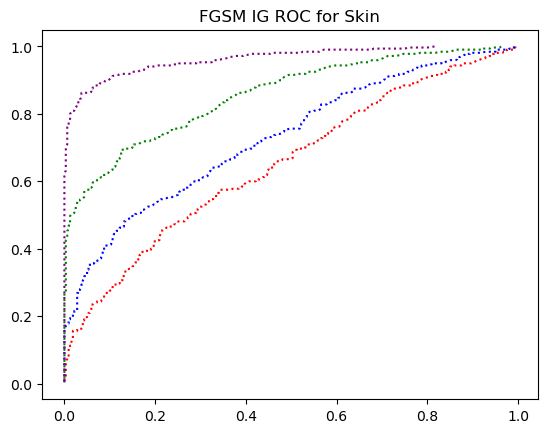

In [40]:
ind = 1
x1, y1 = roc_curve.min_roc_curve(skin_fgsm_ig['ben'][ind], skin_fgsm_ig['fgsm1'][ind], 1000)
x2, y2 = roc_curve.min_roc_curve(skin_fgsm_ig['ben'][ind], skin_fgsm_ig['fgsm2'][ind], 1000)
x3, y3 = roc_curve.min_roc_curve(skin_fgsm_ig['ben'][ind], skin_fgsm_ig['fgsm3'][ind], 1000)
x4, y4 = roc_curve.min_roc_curve(skin_fgsm_ig['ben'][ind], skin_fgsm_ig['fgsm4'][ind], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a, b, c, d in zip(x1, x2, x3, x4):
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    if abs(b - 0.1) < abs(fpr_res[1] - 0.1):
        fpr_res[1] = b
        tpr_res[1] = y2[i]
    if abs(c - 0.1) < abs(fpr_res[2] - 0.1):
        fpr_res[2] = c
        tpr_res[2] = y3[i]
    if abs(d - 0.1) < abs(fpr_res[3] - 0.1):
        fpr_res[3] = d
        tpr_res[3] = y4[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.title("FGSM IG ROC for Skin")
plt.plot(x1, y1,   "red", linestyle = 'dotted', label = "FGSM 8/255")
plt.plot(x2, y2, "blue", linestyle = 'dotted', label = "FGSM 16/255")
plt.plot(x3, y3, "green", linestyle = 'dotted', label = "FGSM 32/255")
plt.plot(x4, y4, "purple", linestyle = 'dotted', label = "FGSM 64/255")
plt.show()